# 9. DL実用
## 概要

本演習では画像認識ネットワークの判断根拠を可視化する CAM および Grad-CAM をライブラリを用いて実装します。

なお、予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。演習問題文は<font color="Red">赤字</font>です。

所要時間：<font color="Red">3~5時間</font>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install torch==1.13.0 torchvision==0.14.0 torchcam==0.3.2 grad-cam==1.4.6
else:
    print("Not Google Colab")

### 【Google colabのみ実行】ドライブのマウント

Google Colabでは、**マウント**という作業を行って、Googleドライブ内のファイルを操作できる状態にする必要があります。<br>
<br>
以下のコードを実行してマウントしてください。なお、認証で**Googleアカウントへのログインが必要**になります。

In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

### ファイル操作

手持ちのデータをcolabで使用するには、データをGoogleドライブ内のフォルダに上げる必要があります。<br>

**画面左側のファイルマークのボタン**をクリックして、ドライブ内のファイルリストを開いてください。<br>

すると「drive」「sample_data」というフォルダがあり、「drive」がマイドライブや共有ドライブの入っているフォルダになります。<br>
<br>
この「drive」フォルダの中でアップロードしたい場所を選び、**右クリック(または3点リーダー「⋮」をクリック)から「アップロード」を押して**、今回使用するファイル<font color="Red">「cat_1.png」「cat_2.png」「cat_3.png」</font>をアップしましょう。<br>
<br>
アップロードしたファイルをコードの関数内で参照する際は右クリックで「パスをコピー」を選択し、コードに貼り付けましょう。<br>

### ライブラリのインポート

必要なライブラリのインストールを行います。

In [ ]:
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torchvision
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

import torchcam
from torchcam.utils import overlay_mask
from torchcam.methods import CAM
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

### Pathの設定

画像や学習済みパラメータを読み込むためのPathを設定します。

In [ ]:
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    premodel_path = '/content/drive/MyDrive/resnet18_cifar10_epoch_9.pth'
    airplane_path = '/content/drive/MyDrive/airplane.png'
    cat_1_path = '/content/drive/MyDrive/cat1.png'
    cat_2_path = '/content/drive/MyDrive/cat2.png'
    cat_3_path = '/content/drive/MyDrive/cat3.png'
else:
    premodel_path = 'resnet18_cifar10_epoch_9.pth'
    airplane_path = 'airplane.png'
    cat_1_path = 'cat1.png'
    cat_2_path = 'cat2.png'
    cat_3_path = 'cat3.png'

### 分析に用いるネットワークの準備

分析対象として、あらかじめ学習された resnet18 というネットワークを使用します。

以下でその準備を行います。

In [ ]:
# モデルの準備
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(in_features=512, out_features=10)

# 学習済みパラメータの読み込み
model.load_state_dict(torch.load(premodel_path))

In [ ]:
# ネットワークの出力した index と
# cifar10 データセットに含まれる物体クラス名を変換する
# List を用意
idx_to_classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
# （例）ネットワークの出力が１となる場合、automobile と出力される
print(idx_to_classes[1])

用意した`resnet18`のアーキテクチャを確認しましょう。

In [ ]:
model

## 1. CAMによる判断可視化

CAMは、CNNの最後の重みを用いて画像のどの部分に注目して推測したかを可視化する手法です。  
Global Average Pooling (GAP)を含むモデルで使用することができます。  
以下の図のように、GAP後の最終層の重みをそれぞれの関連する特徴マップに掛け合わせて重みづけを行い、それらを足し合わせたものが特徴マップになります。

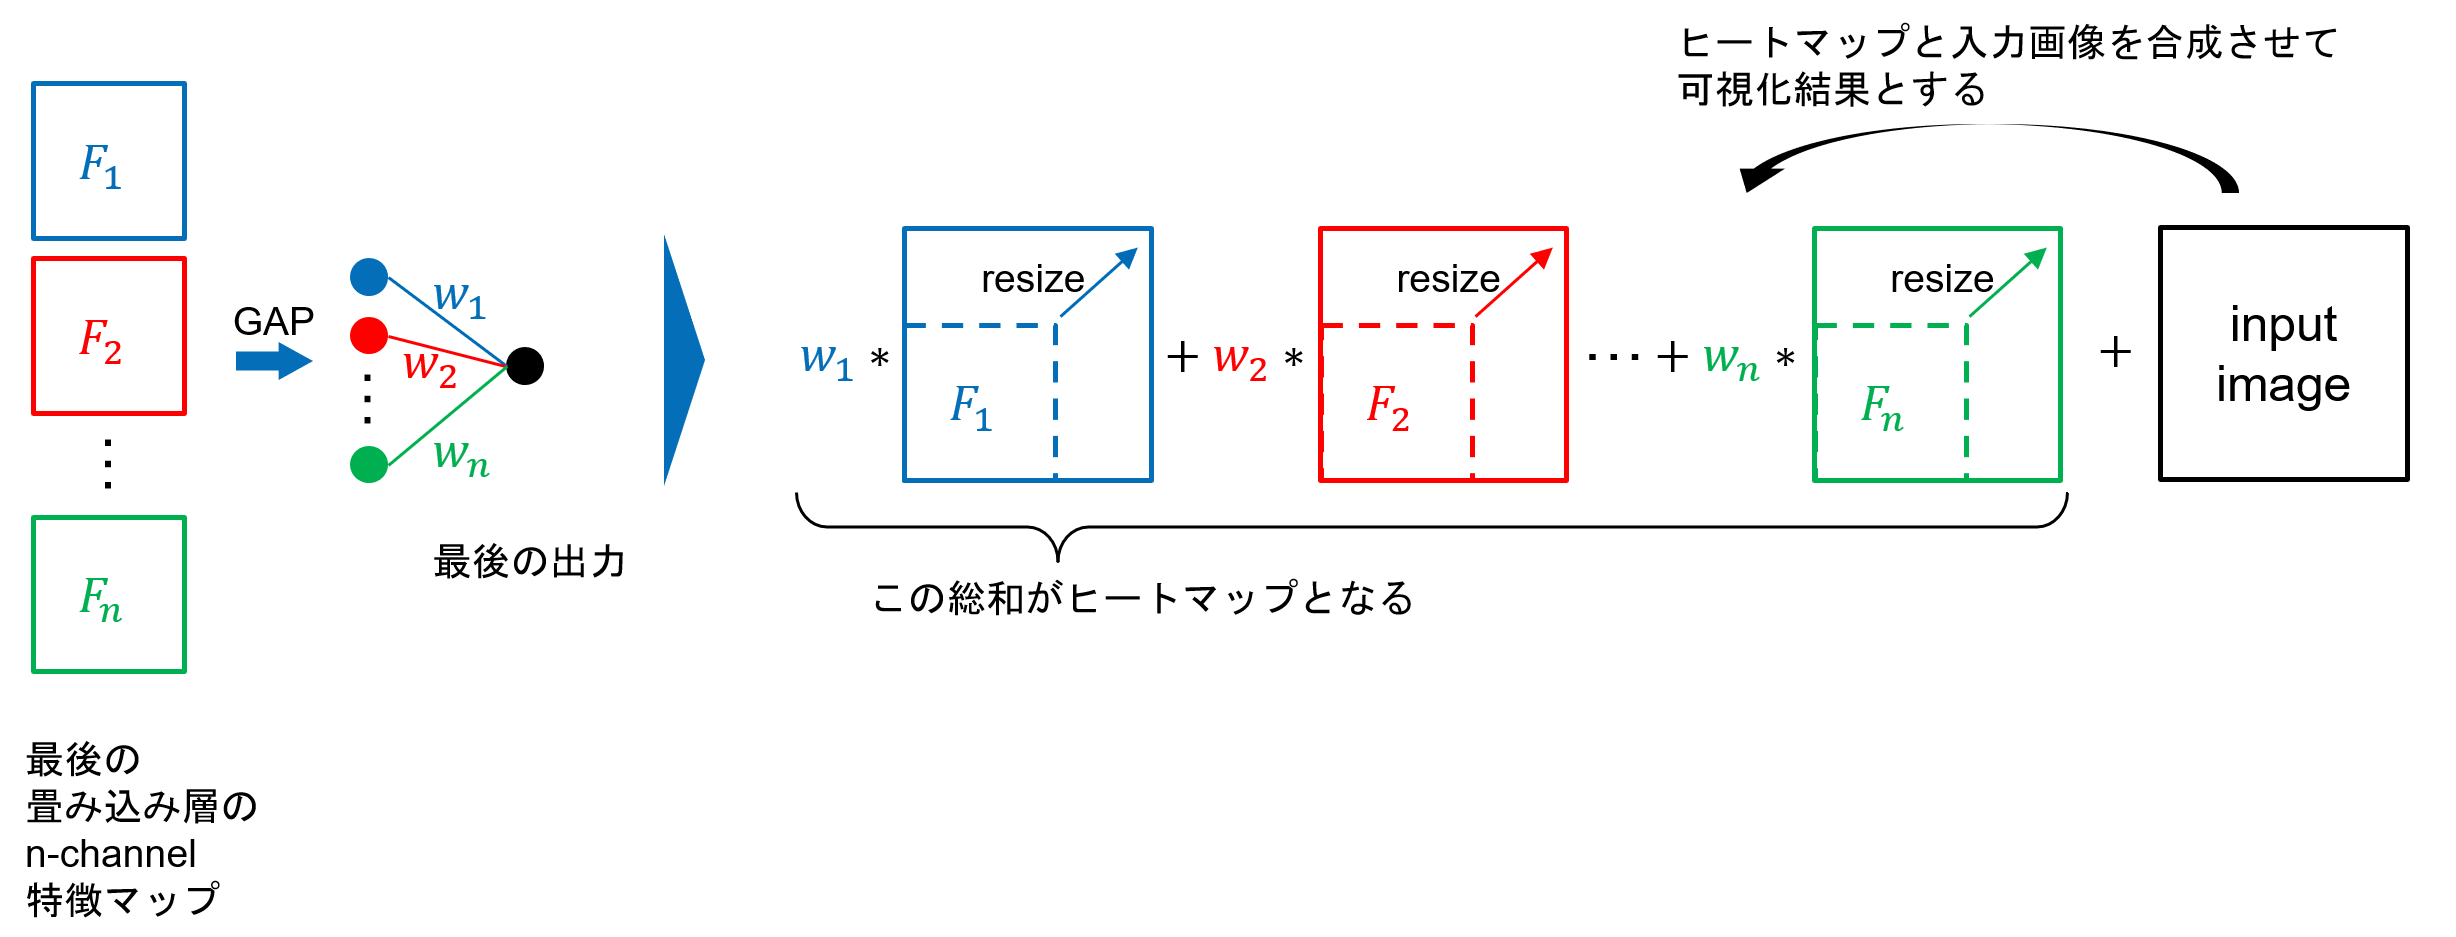

まず、飛行機画像の認識および判断根拠の可視化を行います。

### 飛行機画像の読み込み、表示

本演習では、以降で何度も画像を表示する必要があるため、関数化しておきます。

In [ ]:
def show_image(img):
    if isinstance(img, Tensor):
        img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# 飛行機の画像をテンソルとして読み込み
img_airplane = read_image(airplane_path)

# 可視化
show_image(img_airplane)

### 認識結果の確認

先ほど用意したネットワークが飛行機画像を認識できるか試してみましょう。

In [ ]:
# 画像を正規化
input_tensor = normalize(resize(img_airplane, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# ネットワークによる推論
model.eval()
with torch.no_grad():
    out = model(input_tensor.unsqueeze(0))

# 推論結果の表示
target_category = out.squeeze(0).argmax().item()
print("推論結果：{}".format(idx_to_classes[target_category]))

### CAM の実装、可視化

CAMを使用してモデルが画像のどの部分に注目しているか確認しましょう。

* <font color="Red">問1. 事前に用意したresnet18における`layer4`を抽出する処理を記述してください。</font>

  * 【ヒント】引数`target_layer`で抽出する層を指定できます。
  * CAMの引数について

    1. model : 使用するモデル
    2. target_layer: 判断根拠を可視化したいモデルの畳み込み層を指定
    3. fc_layer: モデルの全結合層を指定

* <font color="Red">問2. 飛行機の画像`input_tensor`をresnet18に入力したときの出力を取得する処理を記述してください。</font>

In [ ]:
# CAMの準備
cam_extractor = ### 問1 ###

# ネットワークによる推論
#（CAMを宣言した後に、ネットワークを実行する必要があるため、もう一度実行しています。）
model.eval()
with torch.no_grad():
    out = ### 問2 ###

# 推論結果の表示
target_category = out.squeeze(0).argmax().item()
print("推論結果：{}".format(idx_to_classes[target_category]))

# CAMにより、ヒートマップを得る
activation_map = cam_extractor(target_category, out)

# ヒートマップを入力画像に重ね合わせ、モデルがどの部分に注目しているかを確認
result = overlay_mask(
    to_pil_image(img_airplane),
    to_pil_image(activation_map[0], mode='F'),
    alpha=0.6
)

show_image(result)

## 2. Grad-CAMによる判断可視化

Grad-CAMは、CAMと同様にCNNの判断根拠の可視化を行う手法です。  
CAMではGAP後の重みを用いて特徴マップを重みづけしていたのに対して、Grad-CAMでは以下の図のように可視化したい畳み込み層の逆伝播時の勾配を用いて特徴マップを重みづけしています。  
勾配を用いて重みを計算しているため、CAMのようにGAPを必要とせず最後の畳み込み層だけでなく、中間の畳み込み層の可視化も可能になるといった特徴があります。

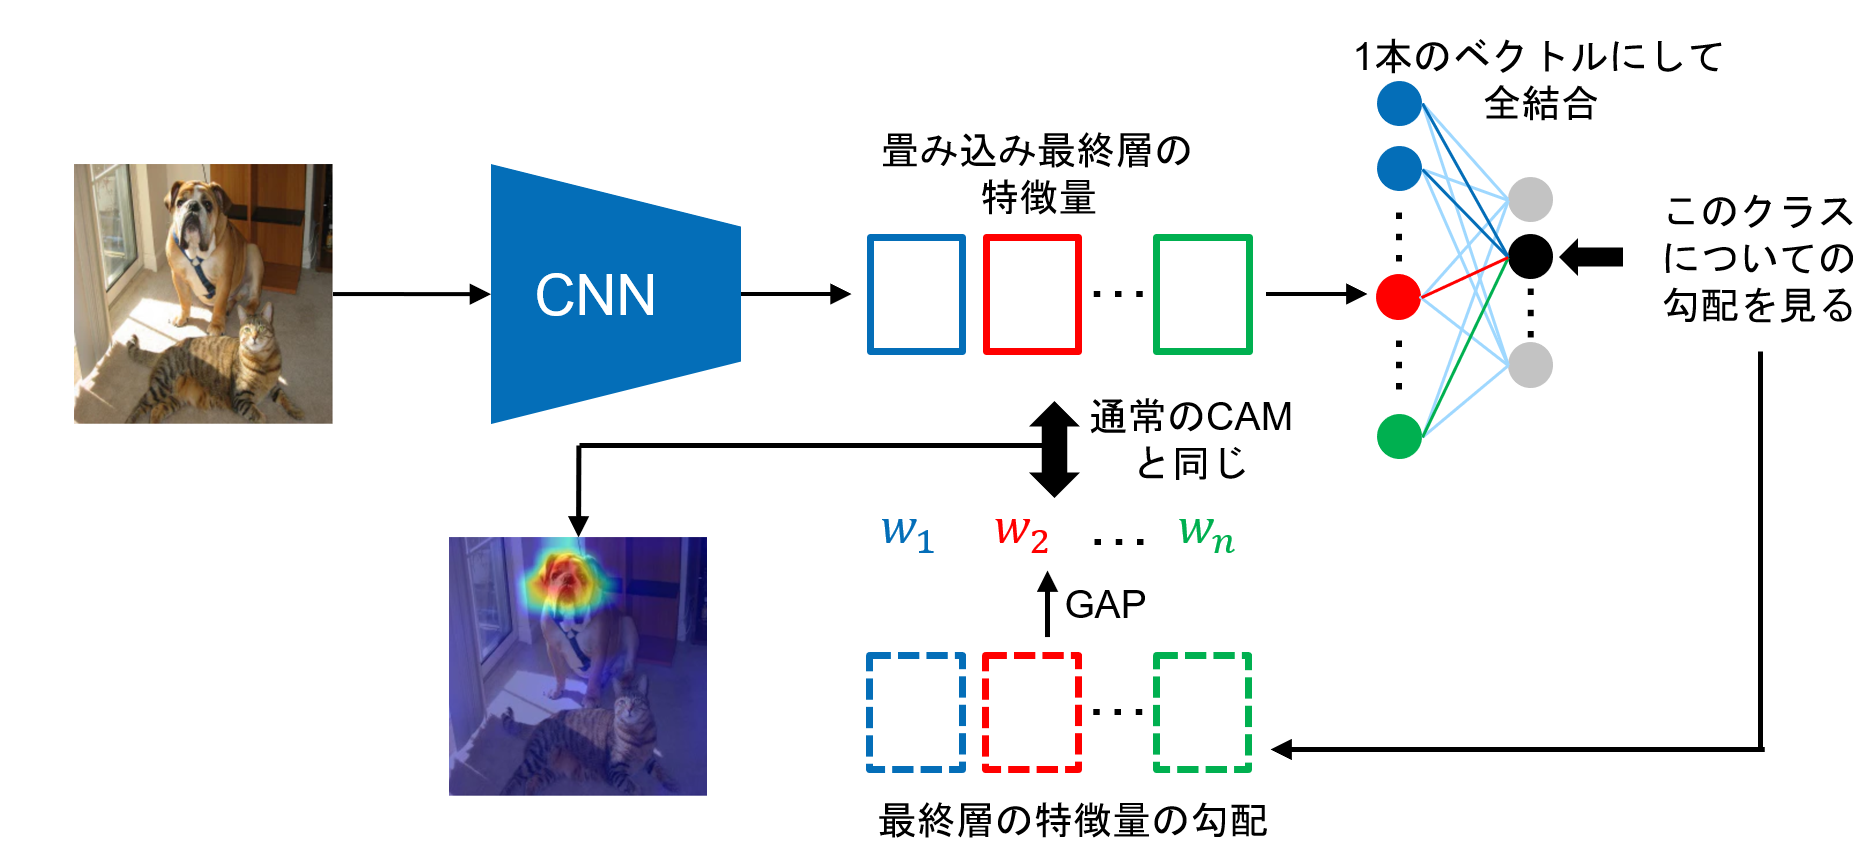

次に、3枚の猫画像を用いて Grad-CAM による判断根拠の可視化、および誤認識理由の分析を行います。


### 猫画像の読み込み、表示

In [ ]:
# 猫の画像１をテンソルとして読み込み
img_cat_1 = read_image(cat_1_path)
# 表示
print("cat_1")
show_image(img_cat_1)

# 猫の画像２をテンソルとして読み込み
img_cat_2 = read_image(cat_2_path)
# 表示
print("cat_2")
show_image(img_cat_2)

# 猫の画像３をテンソルとして読み込み
img_cat_3 = read_image(cat_3_path)
# 表示
print("cat_3")
show_image(img_cat_3)

### 認識結果の確認

先ほど用意したネットワークが猫画像を認識できるか試してみましょう。
* <font color="Red">問3. 飛行機の画像`input_tensor`をresnet18に入力したときの出力を取得する処理を記述してください。</font>

In [ ]:
def recognize(img):
    # 画像を正規化
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # ネットワークによる推論
    model.eval()
    with torch.no_grad():
        out = ### 問3（問2と同じ） ###

    # 推論結果の表示
    target_category = out.squeeze(0).argmax().item()
    print("認識結果：{}".format(idx_to_classes[target_category]))

In [ ]:
# 猫画像１の認識
print("猫画像１")
recognize(img_cat_1)

# 猫画像２の認識
print("猫画像２")
recognize(img_cat_2)

# 猫画像３の認識
print("猫画像３")
recognize(img_cat_3)

猫画像１のみ、誤認識しています。

### feature層の切り出し

Grad-CAM で可視化するネットワークの層を切り出します。  
まずは、最後の畳み込み層に注目して切り出します。  
resnet18 の feature 層には、layer1 から layer4 まであります。

<font color="Red">問4. ネットワークから最後の畳み込み層を切り出してください。
</font>

【ヒント】事前に確認した`resnet18`のアーキテクチャを確認し、最後の畳み込み層`Conv2`がどこに位置するのか確認しましょう。

In [ ]:
# feature層の切り出し
target_layer = ### 問4 ###

### Grad-CAM の実装、および実行

こちらでも、複数の画像について共通の処理を行うため、Grad-CAM を実行する部分を関数として実装します。

* <font color="Red">問5. Grad-CAM を実行する関数を完成させてください。</font>
  * <font color="Red">問5-1. Grad-CAM のインスタンスを生成する処理を記述して下さい。`GradCAM`の引数は『判断根拠を確認するモデル』と『判断根拠を確認するモデルのレイヤのリスト』を指定します。</font>

In [ ]:
# Grad-CAM を実行する関数
def run_grad_cam(model, img, target_layer, target_category):
    
    # 画像の正規化
    input_tensor = resize(img, (224, 224)) / 255.
    input_tensor = normalize(input_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Grad-CAMの準備
    grad_cam = ### 問5-1 ###

    # Grad-CAMの実行
    grayscale_cam = grad_cam(
        input_tensor=input_tensor.unsqueeze(0),
        targets=[ClassifierOutputTarget(target_category)]
    )
    grayscale_cam = grayscale_cam[0, :]

    # ヒートマップを元の画像に重ねる
    img_np = (resize(img, (224, 224)) / 255.).permute(1, 2, 0).numpy()
    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    # ヒートマップ付き画像の表示
    plt.imshow(visualization)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

問3で実装した関数を用いて、dog と誤認識した猫画像１について Grad-CAM を実行してみます。

* <font color="Red">問6. 猫画像1のどこに注目してdogと誤認識したか、判断根拠を可視化しましょう（誤認識したdogのindexは5とします）。</font>
  * <font color="Red">問6-1. 判断根拠を確認したい画像を指定しましょう。</font>
  * <font color="Red">問6-2. `target_category`を指定しましょう。</font>
  
【ヒント】`run_grad_cam`及び`GradCAM`の引数`target_category`は『どのラベルに分類したか』を指定します。

In [ ]:
# 猫画像１の表示
show_image(img_cat_1)

# Grad-CAMを実行
img =  ### 問6-1 ###
target_category = ### 問6-2 ###
run_grad_cam(model, img, target_layer, target_category)

今度は、正しく認識できた他の猫画像2, 猫画像3について Grad-CAM を実行してみましょう。

* <font color="Red">問7. 猫画像2に対して、`cat`と分類した根拠を可視化する処理を完成させてください。</font>
* <font color="Red">問8. 猫画像3に対して、`cat`と分類した根拠を可視化する処理を完成させてください。</font>

In [ ]:
# 猫画像２の表示
show_image(img_cat_2)

# Grad-CAMを実行
img = ### 問7-1 ###
target_category = ### 問7-2 ###
run_grad_cam(model, img, target_layer, target_category)

In [ ]:
# 猫画像３の表示
show_image(img_cat_3)

# Grad-CAMを実行
img = ### 問8-1 ###
target_category = ### 問8-2 ###
run_grad_cam(model, img, target_layer, target_category)

これまでの結果から、正しく認識できている場合、猫として特徴的な顔の部分に注目していると推測できます。

### target_layerについて

これまでは target_layer として layer4 の最終層を用いていましたが、他の layer についても見てみましょう。


<font color="Red">問9. ネットワークから layer3 の畳み込み層を切り出してください。
</font>

In [ ]:
# feature層の切り出し
target_layer = ### 問8 ###

各画像について、target_category を猫として実行してみます。

In [ ]:
# 猫画像１の表示
show_image(img_cat_1)

# Grad-CAMを実行
target_category = 3
run_grad_cam(model, img_cat_1, target_layer, target_category)

In [ ]:
# 猫画像２の表示
show_image(img_cat_2)

# Grad-CAMを実行
target_category = 3
run_grad_cam(model, img_cat_2, target_layer, target_category)

In [ ]:
# 猫画像３の表示
show_image(img_cat_3)

# Grad-CAMを実行
target_category = 3
run_grad_cam(model, img_cat_3, target_layer, target_category)

layer3 について Grad-CAM を実行した結果とみると、正しく認識できた猫画像２，３に関してはより顔に注目しているようです。

それに対し、誤って認識された猫画像１についてはネットワークがほとんど猫の顔に注目していないことが分かります。

以上のことから、猫画像１が誤認識された理由として、猫の顔と判断するには難しい画像であったからではないかと推測できます。